###Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install dependancies

In [ ]:
!pip install -q torch torchvision pillow

#import deeplabv3+

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101

# Load pre-trained DeepLabV3+ model
model = deeplabv3_resnet101(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 180MB/s]


In [ ]:
# Replace the classifier to match the number of classes in your dataset
import torch.nn as nn

num_classes = 8
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
!pip install -q torch torchvision

#Load the dataset

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


from glob import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import os

class CityscapesCustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, dataset_type="clean", transform=None):
        """
        Custom Cityscapes Dataset.
        - root_dir: Root directory of the dataset containing images and labels.
        - dataset_type: Either "clean" or "adversarial".
        - transform: Transformations to apply to images (labels remain untransformed).
        """
        self.root_dir = root_dir
        self.transform = transform

        # Define subdirectories for images and labels
        if dataset_type == "clean":
            self.image_dir = os.path.join(root_dir, "Clean Images")
        elif dataset_type == "adversarial":
            self.image_dir = os.path.join(root_dir, "Adverserial Images")
        else:
            raise ValueError(f"Unknown dataset_type: {dataset_type}. Use 'clean' or 'adversarial'.")

        self.label_dir = os.path.join(root_dir, "Labels")  # Labels are shared

        # Get list of all images and corresponding labels
        self.image_paths = sorted(os.listdir(self.image_dir))
        self.label_paths = sorted(os.listdir(self.label_dir))

        # Ensure correspondence between images and labels
        assert len(self.image_paths) == len(self.label_paths), "Mismatch between images and labels"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image and label
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])

        # Load image and label
        image = Image.open(image_path).convert("RGB")  # Load as RGB
        label = Image.open(label_path)  # Labels are grayscale

        # Apply transformation to the image only
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor without transformation
        label = torch.tensor(np.array(label), dtype=torch.long)

        return image, label


from torch.utils.data import DataLoader
from torchvision import transforms
import random
from torch.utils.data import ConcatDataset, random_split

# Define transformations
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Root directory containing the dataset folders
root_dir = '/content/drive/MyDrive/Cityscapes/Final_Dataset'

clean_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="clean", transform=image_transform)
adv_dataset = CityscapesCustomDataset(root_dir=root_dir, dataset_type="adversarial", transform=image_transform)

# Combine datasets
combined_dataset = ConcatDataset([clean_dataset, adv_dataset])

# Split into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)

#Define MIoU function

In [ ]:
model.eval()
import torch
import numpy as np

# Function to compute MIoU
import torch
import numpy as np

def calculate_iou(pred, target, num_classes):
    ious = []

    # Flatten predictions and targets across the batch
    pred = pred.view(-1)  # Shape: (batch_size * height * width)
    target = target.view(-1)  # Shape: (batch_size * height * width)

    for cls in range(num_classes):
        # True Positive (intersection)
        intersection = ((pred == cls) & (target == cls)).sum().item()
        # Union
        union = ((pred == cls) | (target == cls)).sum().item()

        if union == 0:
            ious.append(float('nan'))  # Ignore classes not present in the batch
        else:
            ious.append(intersection / union)

    # Calculate mean IoU, ignoring NaN values
    miou = np.nanmean(ious)
    return miou

#Integrate into the Training Loop

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load pre-trained DeepLabV3+ model
model = deeplabv3_resnet101(pretrained=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define function to freeze specific layers
def freeze_layers(model, layer_names):
    for name, param in model.named_parameters():
        if any(layer in name for layer in layer_names):
            param.requires_grad = False

# Define function to unfreeze specific layers
def unfreeze_layers(model, layer_names):
    for name, param in model.named_parameters():
        if any(layer in name for layer in layer_names):
            param.requires_grad = True

# Initial freezing of all layers except classifier
freeze_layers(model, layer_names=["backbone"])
unfreeze_layers(model, layer_names=["classifier"])

# Optimizer with fixed learning rate
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Training loop with gradual unfreezing
num_epochs = 20
layers_to_unfreeze = ["layer4", "layer3", "layer2", "layer1"]  # Backbone layer names to unfreeze progressively
unfreeze_interval = 5  # Number of epochs before unfreezing the next set of layers

# History for plotting
history = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": []
}

best_miou = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Gradually unfreeze layers
    if epoch % unfreeze_interval == 0 and len(layers_to_unfreeze) > 0:
        layer_to_unfreeze = layers_to_unfreeze.pop(0)
        unfreeze_layers(model, layer_names=[layer_to_unfreeze])
        print(f"Unfreezing layer: {layer_to_unfreeze}")

    # Training
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", unit="batch"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")
    history["train_loss"].append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_miou = 0.0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation", unit="batch"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            pred_masks = torch.argmax(outputs, dim=1)

            val_miou += calculate_iou(pred_masks, masks, num_classes=8)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_miou = val_miou / len(val_loader)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation MIoU: {avg_val_miou:.4f}")

    history["val_loss"].append(avg_val_loss)
    history["val_miou"].append(avg_val_miou)

    # Save best model
    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
        print(f"New best model saved with MIoU: {best_miou:.4f}")


Epoch 1/20
Unfreezing layer: layer4


Training: 100%|██████████| 739/739 [02:01<00:00,  6.10batch/s]


Training Loss: 0.6697


Validation: 100%|██████████| 131/131 [00:26<00:00,  4.98batch/s]


Validation Loss: 0.5053
Validation MIoU: 0.5296
New best model saved with MIoU: 0.5296

Epoch 2/20


Training: 100%|██████████| 739/739 [00:29<00:00, 25.32batch/s]


Training Loss: 0.4983


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.90batch/s]


Validation Loss: 0.4718
Validation MIoU: 0.5452
New best model saved with MIoU: 0.5452

Epoch 3/20


Training: 100%|██████████| 739/739 [00:29<00:00, 24.95batch/s]


Training Loss: 0.4694


Validation: 100%|██████████| 131/131 [00:04<00:00, 26.54batch/s]


Validation Loss: 0.4515
Validation MIoU: 0.5535
New best model saved with MIoU: 0.5535

Epoch 4/20


Training: 100%|██████████| 739/739 [00:29<00:00, 25.24batch/s]


Training Loss: 0.4495


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.34batch/s]


Validation Loss: 0.4380
Validation MIoU: 0.5663
New best model saved with MIoU: 0.5663

Epoch 5/20


Training: 100%|██████████| 739/739 [00:29<00:00, 25.44batch/s]


Training Loss: 0.4304


Validation: 100%|██████████| 131/131 [00:04<00:00, 26.70batch/s]


Validation Loss: 0.4313
Validation MIoU: 0.5698
New best model saved with MIoU: 0.5698

Epoch 6/20
Unfreezing layer: layer3


Training: 100%|██████████| 739/739 [00:40<00:00, 18.31batch/s]


Training Loss: 0.4190


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.17batch/s]


Validation Loss: 0.4233
Validation MIoU: 0.5771
New best model saved with MIoU: 0.5771

Epoch 7/20


Training: 100%|██████████| 739/739 [00:40<00:00, 18.12batch/s]


Training Loss: 0.4063


Validation: 100%|██████████| 131/131 [00:04<00:00, 29.48batch/s]


Validation Loss: 0.4217
Validation MIoU: 0.5798
New best model saved with MIoU: 0.5798

Epoch 8/20


Training: 100%|██████████| 739/739 [00:41<00:00, 17.91batch/s]


Training Loss: 0.3949


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.80batch/s]


Validation Loss: 0.4089
Validation MIoU: 0.5890
New best model saved with MIoU: 0.5890

Epoch 9/20


Training: 100%|██████████| 739/739 [00:40<00:00, 18.18batch/s]


Training Loss: 0.3821


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.40batch/s]


Validation Loss: 0.4022
Validation MIoU: 0.5862

Epoch 10/20


Training: 100%|██████████| 739/739 [00:40<00:00, 18.11batch/s]


Training Loss: 0.3732


Validation: 100%|██████████| 131/131 [00:04<00:00, 32.02batch/s]


Validation Loss: 0.4043
Validation MIoU: 0.5935
New best model saved with MIoU: 0.5935

Epoch 11/20
Unfreezing layer: layer2


Training: 100%|██████████| 739/739 [00:42<00:00, 17.44batch/s]


Training Loss: 0.3683


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.00batch/s]


Validation Loss: 0.3938
Validation MIoU: 0.6006
New best model saved with MIoU: 0.6006

Epoch 12/20


Training: 100%|██████████| 739/739 [00:42<00:00, 17.40batch/s]


Training Loss: 0.3579


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.84batch/s]


Validation Loss: 0.3922
Validation MIoU: 0.5992

Epoch 13/20


Training: 100%|██████████| 739/739 [00:43<00:00, 17.15batch/s]


Training Loss: 0.3520


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.81batch/s]


Validation Loss: 0.3880
Validation MIoU: 0.5987

Epoch 14/20


Training: 100%|██████████| 739/739 [00:42<00:00, 17.32batch/s]


Training Loss: 0.3454


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.86batch/s]


Validation Loss: 0.3792
Validation MIoU: 0.6058
New best model saved with MIoU: 0.6058

Epoch 15/20


Training: 100%|██████████| 739/739 [00:42<00:00, 17.41batch/s]


Training Loss: 0.3407


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.88batch/s]


Validation Loss: 0.3656
Validation MIoU: 0.6123
New best model saved with MIoU: 0.6123

Epoch 16/20
Unfreezing layer: layer1


Training: 100%|██████████| 739/739 [00:43<00:00, 16.81batch/s]


Training Loss: 0.3364


Validation: 100%|██████████| 131/131 [00:04<00:00, 32.33batch/s]


Validation Loss: 0.3672
Validation MIoU: 0.6181
New best model saved with MIoU: 0.6181

Epoch 17/20


Training: 100%|██████████| 739/739 [00:44<00:00, 16.73batch/s]


Training Loss: 0.3300


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.58batch/s]


Validation Loss: 0.3752
Validation MIoU: 0.6161

Epoch 18/20


Training: 100%|██████████| 739/739 [00:44<00:00, 16.73batch/s]


Training Loss: 0.3272


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.43batch/s]


Validation Loss: 0.3638
Validation MIoU: 0.6142

Epoch 19/20


Training: 100%|██████████| 739/739 [00:43<00:00, 16.80batch/s]


Training Loss: 0.3214


Validation: 100%|██████████| 131/131 [00:04<00:00, 31.51batch/s]


Validation Loss: 0.3684
Validation MIoU: 0.6147

Epoch 20/20


Training: 100%|██████████| 739/739 [00:44<00:00, 16.64batch/s]


Training Loss: 0.3197


Validation: 100%|██████████| 131/131 [00:04<00:00, 30.46batch/s]


Validation Loss: 0.3521
Validation MIoU: 0.6225
New best model saved with MIoU: 0.6225


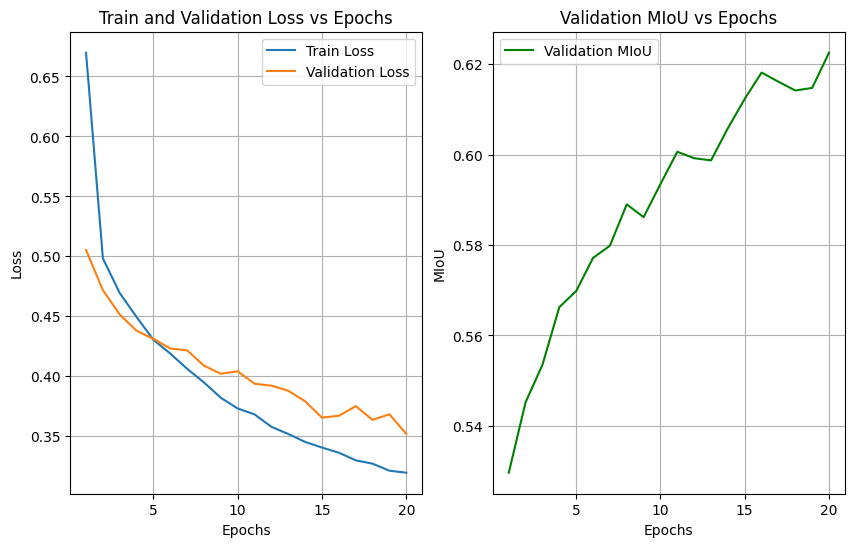

In [ ]:
from matplotlib import pyplot as plt # Plot Training and Validation Loss
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, num_epochs + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss vs Epochs")
plt.legend()
plt.grid(True)


# Plot Validation MIoU
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history["val_miou"], label="Validation MIoU", color="green")
plt.xlabel("Epochs")
plt.ylabel("MIoU")
plt.title("Validation MIoU vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

#Vizualize the model's predictions

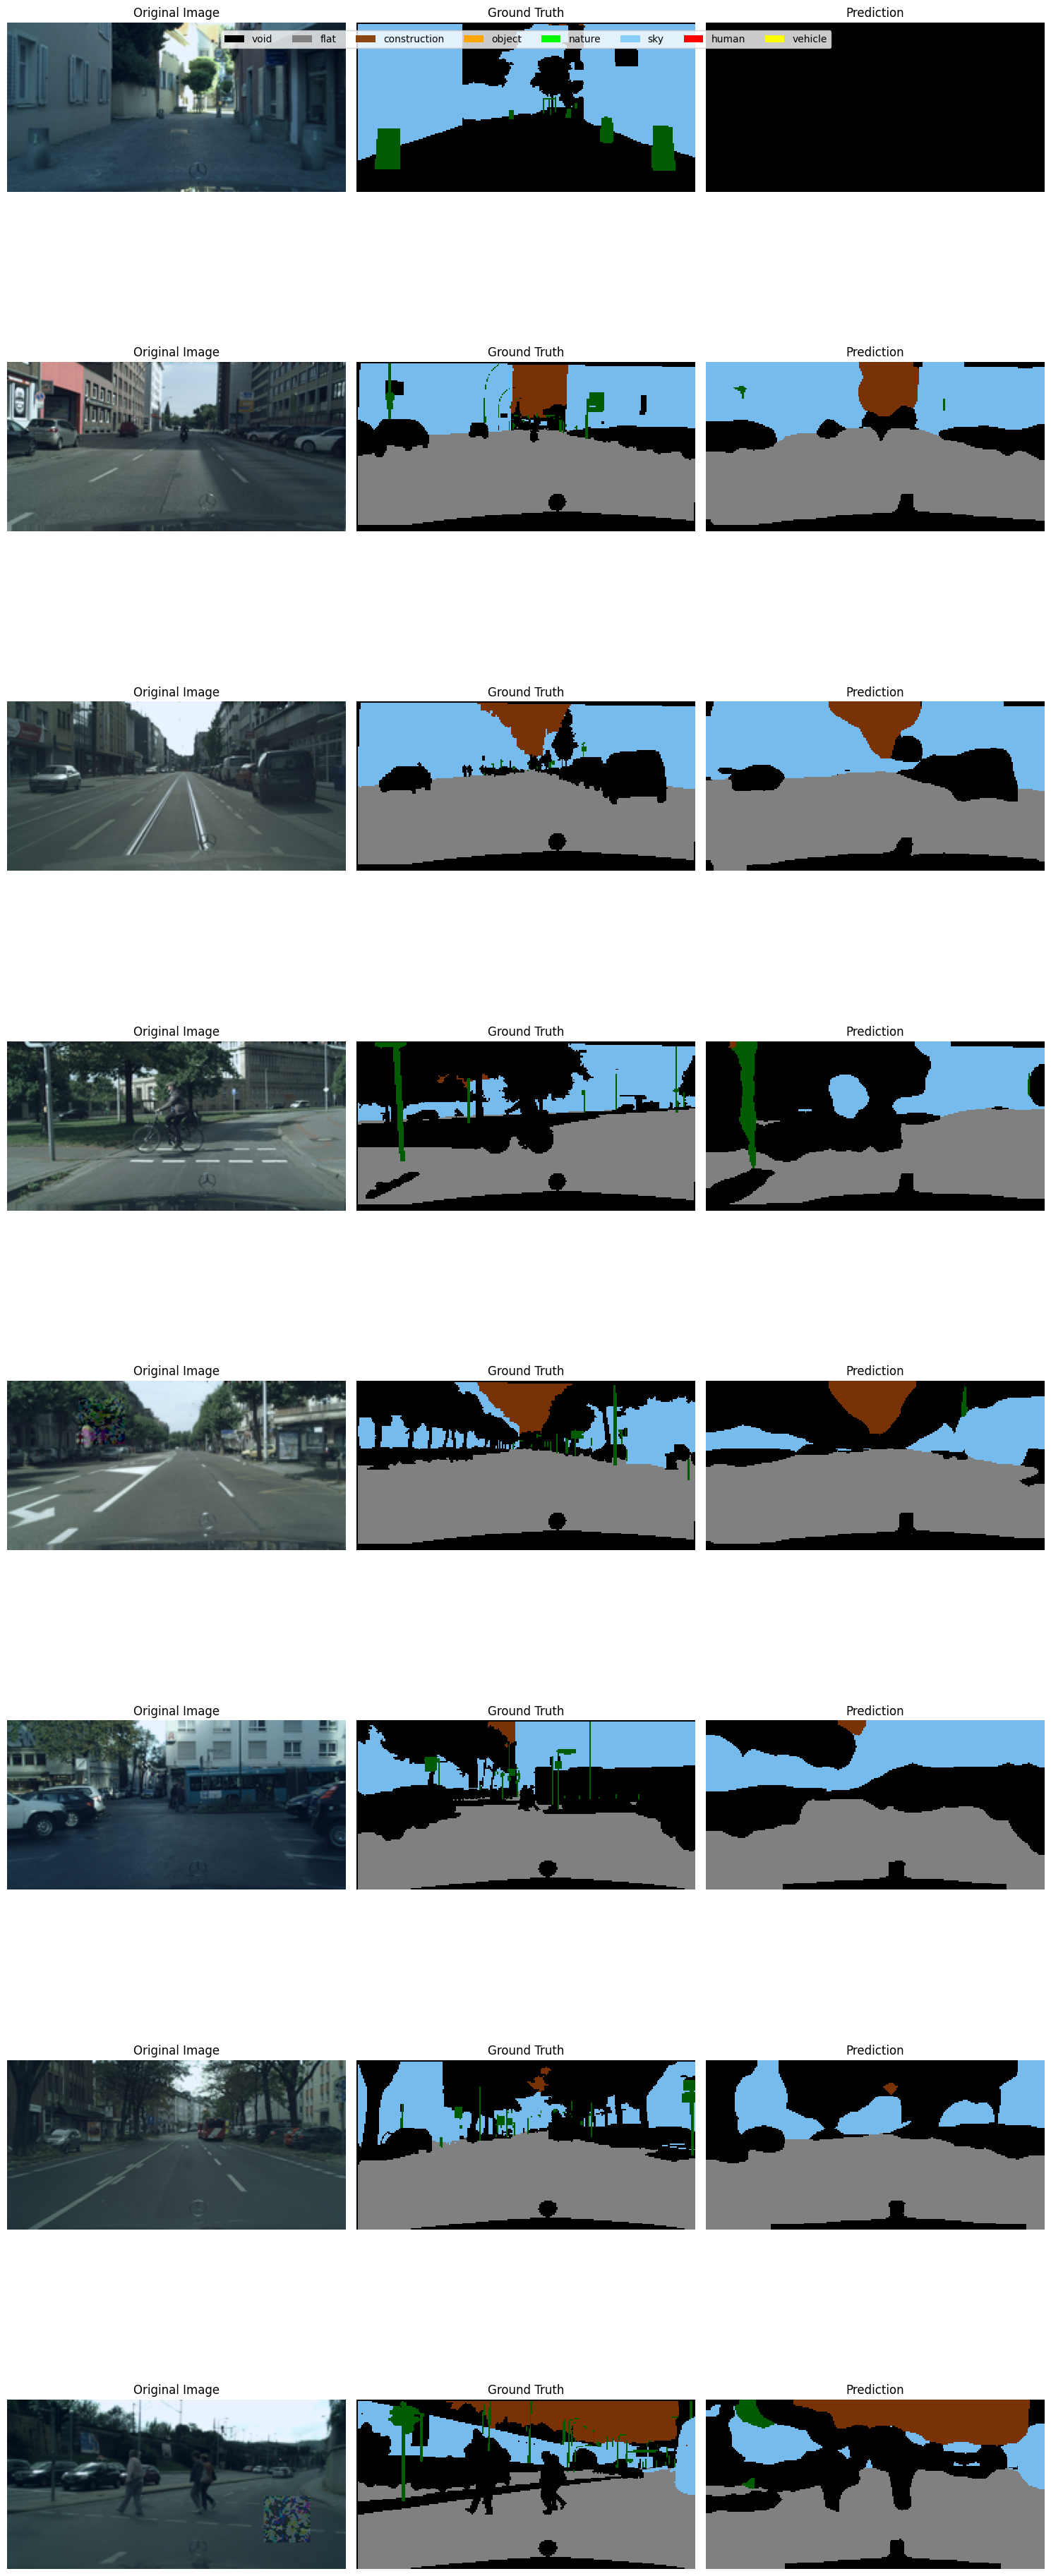

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import torch

def visualize_batch(images, labels, preds, class_colors, class_names=None):

    batch_size = images.shape[0]
    height, width = images.shape[2], images.shape[3]

    # Create color map for segmentation masks
    cmap = ListedColormap(class_colors)

    fig, axes = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))

    for i in range(batch_size):
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (height, width, channels)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        label = labels[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        # Plot original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Plot ground truth with colormap
        im1 = axes[i, 1].imshow(label, cmap=cmap, interpolation="nearest")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Plot prediction with colormap
        im2 = axes[i, 2].imshow(pred, cmap=cmap, interpolation="nearest")
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis("off")

    # Add legend for the segmentation classes
    if class_names is not None:
        # Create color legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=np.array(c) / 255.0, label=cn) for c, cn in zip(class_colors, class_names)]
        fig.legend(handles=legend_elements, loc="upper center", ncol=len(class_names), bbox_to_anchor=(0.5, 0.95))

    plt.tight_layout()
    plt.show()

# Example Usage:
# Simulate one batch of images, labels, and predictions
for images, labels in val_loader:
    images = images.to(device)  # Shape: (batch_size, channels, height, width)
    labels = labels.to(device)  # Shape: (batch_size, height, width)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs["out"], dim=1)

    # Define class colors (example: RGB tuples)
    class_colors = [
    (0, 0, 0),       # void: Black
    (128, 128, 128), # flat: Gray
    (139, 69, 19),   # construction: Brown
    (255, 165, 0),   # object: Orange
    (0, 255, 0),     # nature: Green
    (135, 206, 250), # sky: Blue
    (255, 0, 0),     # human: Red
    (255, 255, 0)    # vehicle: Yellow
        ]


    class_names = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

    # Visualize
    visualize_batch(images, labels, preds, class_colors, class_names)
    break
